In [11]:
import numpy as np
import pandas as pd
from datetime import *
from dateutil import parser
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import os,sys
sys.path.append('../')
from riskpnl.post_trade import batch_summarize_exec_logs

start = datetime(2022,6,23)#,tzinfo=timezone.utc)
log_path = os.path.join(os.sep, 'tmp','prod','tradeexecutor')
log_file = os.path.join(os.sep,'tmp','prod','tradeexecutor','all_by_symbol.csv')
batch_summarize_exec_logs(log_path,start=start,add_history_context=False)
original_weights = pd.read_csv(log_file).sort_values(by='log_time')
original_weights['log_time'] = original_weights['log_time'].apply(parser.parse)

/home/david/Sety-project/pylibs/ux/../riskpnl/post_trade.py:101: RuntimeWarning:

invalid value encountered in double_scalars

/home/david/Sety-project/pylibs/ux/../riskpnl/post_trade.py:102: RuntimeWarning:

invalid value encountered in double_scalars



In [4]:
weights = original_weights[original_weights['log_time']>start.replace(tzinfo=timezone.utc)]

weights['total_bps'] = weights['slippage_bps'] + weights['fee']/weights['filledUSD']*10000
weights['fee_USD'] = weights['fee']
weights['slippage_USD'] = weights['slippage_bps']*weights['filledUSD']/10000
weights['total_USD'] = weights['total_bps']*weights['filledUSD']/10000

### cumulative slippage and fees

In [12]:
weights

,Unnamed: 0,index,time_to_execute,slippage_bps,fee,filledUSD,log_time,total_bps,fee_USD,slippage_USD,total_USD
165,2,AAVE/USD:USD,133860.155029,-63.175365,5.543845,604.33790,2022-06-24 13:44:41+00:00,28.558831,5.543845,-3.817927,1.725918
177,14,SNX/USD,295578.240234,-7.040959,0.000000,-130.68495,2022-06-24 13:44:41+00:00,-7.040959,0.000000,0.092015,0.092015
176,13,MATIC/USD:USD,122001.493896,-27.438681,0.000000,111.03549,2022-06-24 13:44:41+00:00,-27.438681,0.000000,-0.304667,-0.304667
175,12,MATIC/USD,535592.493896,-32.849908,0.000000,-991.49574,2022-06-24 13:44:41+00:00,-32.849908,0.000000,3.257054,3.257054
164,1,AAVE/USD,65568.722168,48.228789,0.000000,-562.39340,2022-06-24 13:44:41+00:00,48.228789,0.000000,-2.712355,-2.712355
...,...,...,...,...,...,...,...,...,...,...,...
380,2,average,NaN,1.860074,0.000000,27.34280,2022-06-25 20:26:51+00:00,1.860074,0.000000,0.005086,0.005086
355,0,SNX/USD:USD,18395.613037,1.761494,0.000000,-0.56760,2022-06-25 20:37:11+00:00,1.761494,0.000000,-0.000100,-0.000100
356,1,average,NaN,1.761494,0.000000,0.56760,2022-06-25 20:37:11+00:00,1.761494,0.000000,0.000100,0.000100
431,0,XRP/USD,61552.960205,64.944296,0.000000,12.39050,2022-06-25 21:08:11+00:00,64.944296,0.000000,0.080469,0.080469


In [13]:
trackrecord = weights[weights['index']=='average'].pivot_table(index='log_time',values=['fee_USD','slippage_USD','total_USD'],aggfunc=np.mean).cumsum()

In [14]:
trackrecord.iplot()

### slippage distribution

<AxesSubplot:>

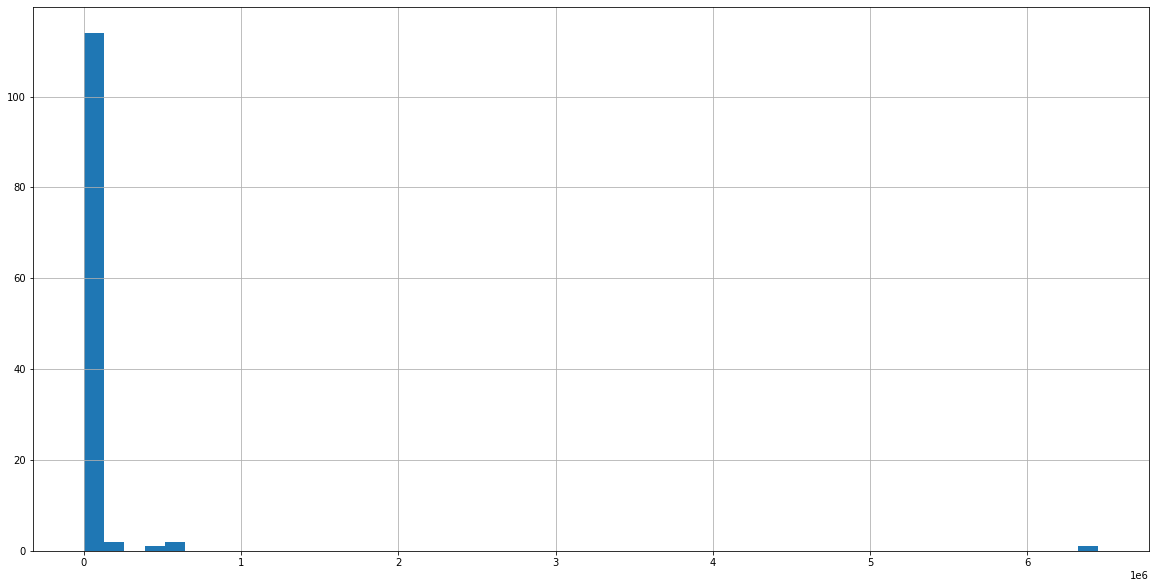

In [15]:
(weights.loc[weights['index']=='average','total_bps']).hist(bins=50,figsize=(20,10))